# Naive Bayes Classifier

In [1]:
import pandas as pd

In [2]:
emails = pd.read_csv('cleaned-movie-dataset.csv')
emails.drop(emails.columns[0], axis=1, inplace=True)
print(emails.shape)
emails.head()

(5172, 3001)


,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Label
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0


In [3]:
emails['Label'].value_counts(normalize=True)

0    0.709977
1    0.290023
Name: Label, dtype: float64

## Training and Test Set

In [4]:
# Randomize the dataset
data_randomized = emails.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print("Training Set:", training_set.shape)
print("Test Set:", test_set.shape)

Training Set: (4138, 3001)
Test Set: (1034, 3001)


In [5]:
training_set['Label'].value_counts(normalize=True)

0    0.711455
1    0.288545
Name: Label, dtype: float64

In [6]:
test_set['Label'].value_counts(normalize=True)

0    0.704062
1    0.295938
Name: Label, dtype: float64

## Creating Vocabulary

In [7]:
vocabulary = list(emails.columns)
vocabulary.remove('Label')
print("Vocabulary length:", len(vocabulary))

Vocabulary length: 3000


## Calculating Constants

In [8]:
# Isolating spam and non-spam messages first
spam_messages = training_set[training_set['Label'] == 1]
non_spam_messages = training_set[training_set['Label'] == 0]

# P(Spam) and P(Non-Spam)
p_spam = len(spam_messages) / len(training_set)
p_non_spam = len(non_spam_messages) / len(training_set)

# N_Spam
n_spam = spam_messages.iloc[:,1:-1].sum().sum()

# N_Non-Spam
n_non_spam = non_spam_messages.iloc[:,1:-1].sum().sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters

In [9]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_non_spam = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum() # spam_messages already defined
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam

    n_word_given_non_spam = non_spam_messages[word].sum() # non_spam_messages already defined
    p_word_given_non_spam = (n_word_given_non_spam + alpha) / (n_non_spam + alpha*n_vocabulary)
    parameters_non_spam[word] = p_word_given_non_spam

## Measuring Spam Filter's Accuracy, Precision, Recall & F1 Score

In [10]:
import math

TP = 0    # True Positive
FP = 0    # False Positive
TN = 0    # True Negative
FN = 0    # False Negative
row = 0

for i in range(len(test_set)):
    message = test_set.iloc[row:row+1, :-1]
    word_count = message.sum()
    p_spam_given_message = p_spam
    p_non_spam_given_message = p_non_spam
    col = 0

    for word in message:
        if word in parameters_spam:
            for count in range(word_count[col]):
                p_spam_given_message += math.log(parameters_spam[word])
        if word in parameters_non_spam:
            for count in range(word_count[col]):
                p_non_spam_given_message += math.log(parameters_non_spam[word])
        col += 1;

    if p_non_spam_given_message > p_spam_given_message:
        if test_set.iloc[row:row+1,-1:].sum().sum() == 0:
            TN += 1
        else:
            FN += 1

    elif p_spam_given_message > p_non_spam_given_message:
        if test_set.iloc[row:row+1,-1:].sum().sum() == 1:
            TP += 1
        else:
            FP += 1

    row += 1

<AxesSubplot:>

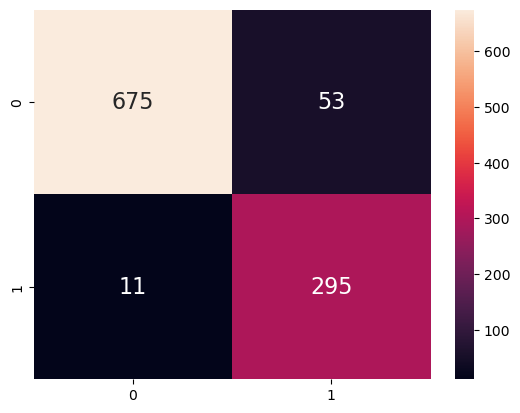

In [11]:
import seaborn as sb
import matplotlib.pyplot as plt

Confusion_Matrix = [[TN, FP],
                    [FN, TP]]

cm_df = pd.DataFrame(Confusion_Matrix, range(2), range(2))
sb.heatmap(cm_df, annot=True,  fmt=".0f", annot_kws={"size": 16})

| Confusion Matrix  |       |        |        |
| :---              | :---: | :----: | :----: |
| Actual Negative   |  (0)  |   TN   |   FP   |
| Actual Positive   |  (1)  |   FN   |   TP   |
|                   |       |   (0)   |   (1)   |
|                   |       | Predicted Negative    |   Predicted Postitive  |

In [12]:
Correct = TP + TN
Incorrect = FP + FN
Accuracy = (TN + TP) / (TN + FP + TP + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_Score = (2 * Precision * Recall) / (Precision + Recall)

print("Correct   :", Correct)
print("Incorrect :", Incorrect)
print("Accuracy  :", Accuracy)
print("Precision :", Precision)
print("Recall    :", Recall)
print("F1 Score  :", F1_Score)

Correct   : 970
Incorrect : 64
Accuracy  : 0.9381044487427466
Precision : 0.8477011494252874
Recall    : 0.9640522875816994
F1 Score  : 0.9021406727828746


## Classifying a New Message

In [13]:
import re

def classify(message):
    '''
    message: a string
    '''

    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    p_spam_given_message = p_spam
    p_non_spam_given_message = p_non_spam

    for word in message:
        if word in parameters_spam:
            p_spam_given_message += math.log(parameters_spam[word])

        if word in parameters_non_spam: 
            p_non_spam_given_message += math.log(parameters_non_spam[word])

        if word not in vocabulary:
            vocabulary.append(word)

            n_word_given_spam = 0
            p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
            parameters_spam[word] = p_word_given_spam

            n_word_given_non_spam = 0
            p_word_given_non_spam = (n_word_given_non_spam + alpha) / (n_non_spam + alpha*n_vocabulary)
            parameters_non_spam[word] = p_word_given_non_spam

    print('P(Spam|message)     :', p_spam_given_message)
    print('P(Non-Spam|message) :', p_non_spam_given_message)

    if p_non_spam_given_message > p_spam_given_message:
        print('Label: Non-Spam')
    elif p_non_spam_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal probabilities, have a human classify this!')

In [14]:
classify("sign up for this scam prize money guaranteed")

P(Spam|message)     : -59.02629883921614
P(Non-Spam|message) : -63.56031284216574
Label: Spam
